Import tensorflow and other modules.

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_hub as hub
import tensorflow_datasets as tfds
from tensorflow.keras import layers
import logging

logger = tf.get_logger()
logger.setLevel(logging.ERROR)

Download and seperate dataset into training and validation.

In [ ]:
(training_set, validation_set), dataset_info = tfds.load(
    'tf_flowers',
    with_info=True,
    as_supervised=True,
    split=['train[:70%]', 'train[70%:]'],
)

Print information about dataset.

In [ ]:
num_classes = dataset_info.features['label'].num_classes

num_training_examples = 0
num_validation_examples = 0

for example in training_set:
  num_training_examples += 1

for example in validation_set:
  num_validation_examples += 1

print('Total Number of Classes: {}'.format(num_classes))
print('Total Number of Training Images: {}'.format(num_training_examples))
print('Total Number of Validation Images: {} \n'.format(num_validation_examples))

Total Number of Classes: 5
Total Number of Training Images: 2569
Total Number of Validation Images: 1101 



Create new modle architecture using pretrained inception model.

In [ ]:
IMAGE_RES = 299

URL = "https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4"

feature_extractor = hub.KerasLayer(URL,
  input_shape=(IMAGE_RES, IMAGE_RES, 3),
  trainable=False)

model_inception = tf.keras.Sequential([
  feature_extractor,
  tf.keras.layers.Dense(num_classes)
])

model_inception.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_3 (KerasLayer)  (None, 2048)              21802784  
                                                                 
 dense_3 (Dense)             (None, 5)                 10245     
                                                                 
Total params: 21813029 (83.21 MB)
Trainable params: 10245 (40.02 KB)
Non-trainable params: 21802784 (83.17 MB)
_________________________________________________________________


Compile new model.

In [ ]:
model_inception.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

Train new model.

In [ ]:
EPOCHS = 6
BATCH_SIZE = 32

def format_image(image, label):
  image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0
  return image, label

train_batches = training_set.shuffle(num_training_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_set.map(format_image).batch(BATCH_SIZE).prefetch(1)

history = model_inception.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/6
81/81 [==============================] - 20s 183ms/step - loss: 0.7644 - accuracy: 0.7178 - val_loss: 0.4542 - val_accuracy: 0.8629
Epoch 2/6
81/81 [==============================] - 14s 171ms/step - loss: 0.3970 - accuracy: 0.8743 - val_loss: 0.3539 - val_accuracy: 0.8910
Epoch 3/6
81/81 [==============================] - 15s 183ms/step - loss: 0.3123 - accuracy: 0.9046 - val_loss: 0.3167 - val_accuracy: 0.8937
Epoch 4/6
81/81 [==============================] - 14s 169ms/step - loss: 0.2678 - accuracy: 0.9175 - val_loss: 0.3284 - val_accuracy: 0.8828
Epoch 5/6
81/81 [==============================] - 15s 180ms/step - loss: 0.2405 - accuracy: 0.9288 - val_loss: 0.2914 - val_accuracy: 0.9028
Epoch 6/6
81/81 [==============================] - 15s 182ms/step - loss: 0.2058 - accuracy: 0.9404 - val_loss: 0.2777 - val_accuracy: 0.9037


Plot training and validation garphs.

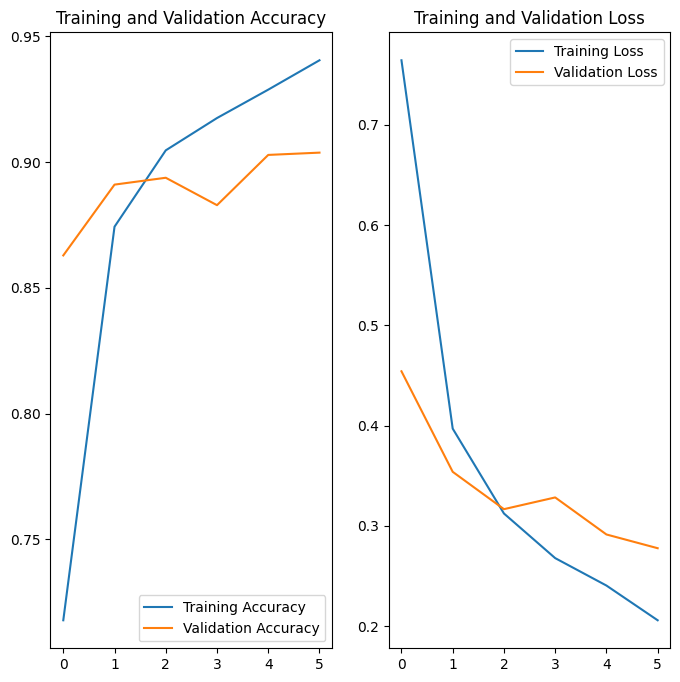

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()